In [ ]:
# cd /home/nymath/dev/HuaTAI/

# 环境配置

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import typing

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [52]:
device = torch.device("mps")

## 讯号模拟

In [53]:
x = torch.linspace(0, 799, 800, device=device)
y = torch.sin(x*2*3.1416/40)

In [54]:
test_size = 40
len_seq = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

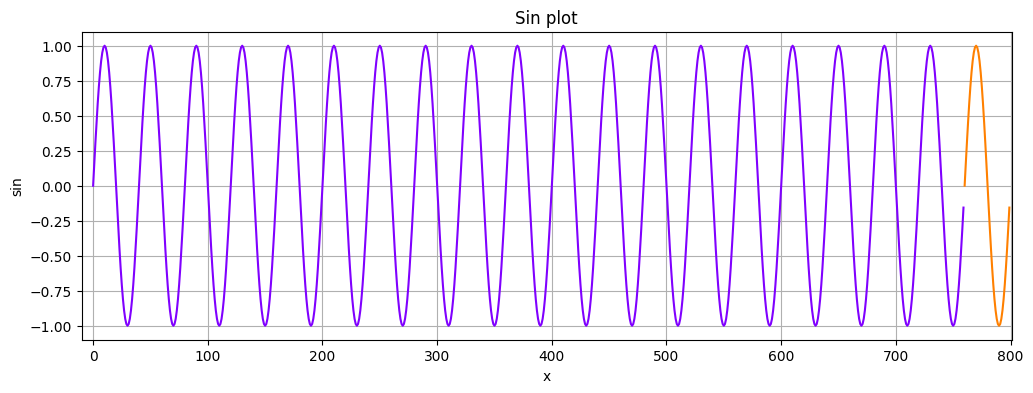

In [55]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("sin")
plt.title("Sin plot")
plt.plot(train_set.cpu().numpy(),color='#8000ff')
plt.plot(range(760,800),test_set.cpu().numpy(),color="#ff8000")
plt.show()

In [56]:
def create_data_set(seq, len_seq):
    out = []
    L = len(seq)

    for i in range(len_seq-1, L-1):
        window = seq[i+1-len_seq:i+1].unsqueeze(-1)
        label = seq[i+1]
        out.append((window,label))
    return out

In [57]:
data_tmp = create_data_set(train_set, 40)

In [58]:
class MySet(Dataset):
    def __init__(self, data_all):
        self.data = data_all

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [59]:
train_data_set = MySet(data_tmp)

In [60]:
train_loader = DataLoader(dataset=train_data_set, batch_size=16, shuffle=False)

In [61]:
# 定义NN
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(hidden_size, output_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, input: torch.Tensor, init_state: typing.Tuple=None):
        if init_state is None:
            init_state = (torch.zeros(1, input.size(0), self.hidden_size, dtype=input.dtype, device=input.device),
                  torch.zeros(1, input.size(0), self.hidden_size, dtype=input.dtype, device=input.device))
        hidden_states, last_hidden_cell_state = self.lstm(input, init_state)
        pred = self.linear(hidden_states[:,-1,:])
        return pred

In [62]:
model = LSTM()
model.to(device)

LSTM(
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (lstm): LSTM(1, 50, batch_first=True)
)

In [63]:
lr = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [64]:
epochs = 10
forecast_steps = 40

In [65]:
train_iter = iter(train_loader)
while True:
    try:
        x_batch, y_batch = next(train_iter)
        y_pred = model(x_batch)
        loss = criterion(y_pred.view(-1), y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    except StopIteration:
        break

preds = train_set[-len_seq:].tolist()
for f in range(forecast_steps):
    seq = torch.Tensor(preds[-len_seq:])
    seq = seq.to(device)
    with torch.no_grad():
        preds.append(model(seq.view(1, -1, 1)).item())

loss = criterion(torch.tensor(preds[-len_seq:], device=device).view(-1), y[760:])
print(f"Performance on test range: {loss}")

plt.figure(figsize=(12,4))
plt.xlim(700,801)
plt.grid(True)
plt.plot(y.cpu().numpy(),color='#8000ff')
plt.plot(range(760,800),preds[len_seq:],color='#ff8000')
plt.show()

NotImplementedError: The operator 'aten::lerp.Scalar_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [45]:
def predict(model, steps, warm_star):
    model.eval()
    preds = warm_star[-len_seq:].tolist()
    for i in range(steps):
        seq = torch.Tensor(preds[-len_seq:])
        seq = seq.to(device)
        with torch.no_grad():
            preds.append(model(seq.view(1, -1, 1)).item())
    return preds[-steps:]